# Chatbot

Options :

In [1]:
train_model = True
#train_model = False

In [2]:
api = False
#api = True

In [3]:
#test = False
test = False

Importer les modules nécessaires :

In [4]:
import json
import pandas as pd
from nltk.stem.snowball import FrenchStemmer, EnglishStemmer
from nltk.corpus import stopwords
from langdetect import detect_langs
import unicodedata
import pickle

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense,GlobalMaxPooling1D,Flatten
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.backend import clear_session

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import random
import numpy as np

from flask import Flask, render_template, request

import pickle

Obtenir la DataFrame à partir de ``content.json`` :

In [5]:
#ouvrir le fichier JSON
from API.connecteur import Connecteur

In [6]:
data1 = Connecteur.get_all_data()

In [7]:
#créer les listes vides
tags = []
inputs = []
responses={}
#les remplir avec le contenu du JSON
for intent in data1['intents']:
    responses[intent['tag']]=intent['liste_output']
    if intent['tag'][:2] != 'en':
        for lines in intent['liste_input']:
            inputs.append(lines)
            tags.append(intent['tag'])
    
#convertir en DataFrame
data = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

#mélanger aléatoirement
data = data.sample(frac=1)

#montrer la DataFrame
display(data)
#montrer les catégories
data["tags"].value_counts()

,inputs,tags
926,Est-ce que je peux venir en bus ?,permis
778,En tant qu'entreprise puis-je proposer des suj...,sujet
181,Quel niveau d’étude doit-on avoir ?,admission
914,Est-ce que l'entreprise peut me fournir un ...,logement
75,Pourrais-je devenir étudiant ?,apprenant
...,...,...
1066,Où postuler ?,postuler
177,Où on s’inscrit ?,admission
656,"Je veux être partenaire, qui dois-je contacter ?",contacts
637,Apprendra-t-on Python ?,techs


debouches          47
apprenant          47
admission          42
affirmation        39
ia                 38
partenaire         38
covid              36
fin                36
alternance         33
techs              33
code               32
evaluation         31
pédagogie          31
salarie            31
nombre_promo       27
titre              27
salutation         26
tuteur             25
selection          23
date               23
duree              22
pas_demandeur      22
choix_alternant    22
nombre_recruter    22
contacts           22
structure          21
permis             21
postes             21
negation           20
contrat            20
conditions         19
postuler           19
cout_partenaire    18
contribution       18
personne           15
adresser           15
simplon            14
aide financiere    14
sujet              13
logement           13
suivi              13
materiel           12
niveau_fin         11
compétences         8
insultes            5
Name: tags

Créer les fonctions de traitement du texte :

In [8]:
#enlever les accents du texte
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return str(only_ascii)[2:-1]

In [9]:
#définir les stopwords
stop_words_en = list(set(stopwords.words('english')))
stop_words_fr = list(set(stopwords.words('french')))

#rajouter aux stopwords français leurs versions sans accents
stop_words_fr_1 = []
for word in stop_words_fr:
    word = remove_accents(word)
    stop_words_fr_1.append(word)
stop_words_fr = list(sorted(set(stop_words_fr + stop_words_fr_1)))

In [10]:
#traiter le texte
def treatment(text):
    #vérifier si c'est une question
    if text[-1] == "?":
        question = "?"
    else:
        question = "0"
        
    #vérifier la langue
    language_list = detect_langs(text)
    language_list_2 = []
    for language in language_list:
        language = str(language).split(":")[0]
        language_list_2.append(language)
    if "fr" in language_list_2:
        language = "francais"
    elif "en" in language_list_2:
        language = "anglais"
    else:
        language = "francais"
    
    #segmenter le texte et traiter chaque mot et chaque lettre
    text = text.split()
    words_list = []
    for word in text:
        letters_list = []
        for character in word:
            #vérifier que le caractère est une lettre
            if character.isalpha():
                #rajouter à la liste en minuscule
                letters_list.append(character.lower())
            else:
                letters_list.append(" ")
        word = "".join(letters_list)
        
        #appliquer le stemming suivant la langue
        for word1 in word.split():
            word_yes = False
            if language == "anglais":
                if word1 not in stop_words_en:
                    word1 = EnglishStemmer().stem(word1)
                    word_yes = True
            else:
                if word1 not in stop_words_fr:
                    word1 = FrenchStemmer().stem(word1)
                    word_yes = True
            #enlever les accents
            if word_yes == True:
                word1 = remove_accents(word1)
                words_list.append(word1)
            
    #joindre en une string
    text = " ".join(words_list)
    return " ".join([text, question, language])
    #pour avoir en trois colonnes
    #return [text, question, language]

Obtenir une colonne avec les inputs traités :

In [11]:
#pour avoir en trois colonnes

#text_list = []
#ques_list = []
#lang_list = []

#for value in data["inputs"]:
    #value = treatment(value)
    #text_list.append(value[0])
    #ques_list.append(value[1])
    #lang_list.append(value[2])

#data["text"] = text_list
#data["?"] = ques_list
#data["language"] = lang_list

In [12]:
data["texts"] = data["inputs"].apply(treatment)

In [13]:
data

,inputs,tags,texts
926,Est-ce que je peux venir en bus ?,permis,peux ven bus 0 francais
778,En tant qu'entreprise puis-je proposer des suj...,sujet,tant entrepris puis propos sujet 0 francais
181,Quel niveau d’étude doit-on avoir ?,admission,quel niveau etud doit avoir ? francais
914,Est-ce que l'entreprise peut me fournir un ...,logement,entrepris peut fourn log 0 francais
75,Pourrais-je devenir étudiant ?,apprenant,pourr deven etudi ? francais
...,...,...,...
1066,Où postuler ?,postuler,ou postul ? francais
177,Où on s’inscrit ?,admission,ou inscrit ? anglais
656,"Je veux être partenaire, qui dois-je contacter ?",contacts,veux etre partenair dois contact ? francais
637,Apprendra-t-on Python ?,techs,apprendra python ? anglais


Appliquer le tokenizer sur les inputs traités :

In [14]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['texts'])
with open('tokenizer_fr.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

train = tokenizer.texts_to_sequences(data['texts'])
#apply padding
x_train = pad_sequences(train)

In [15]:
x_train

array([[  0,   0,   0, ..., 329,   2,   1],
       [  0,   0,   0, ...,  39,   2,   1],
       [  0,   0,   0, ...,  43,  35,   1],
       ...,
       [  0,   0,   0, ...,  69,  29,   1],
       [  0,   0,   0, ..., 485,  44,  18],
       [  0,   0,   0, ..., 116,  44,   1]])

Appliquer LabelEncoder() sur les tags :

In [16]:
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

with open('labelencoder_fr.pickle', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
input_shape = x_train.shape[1]
print(input_shape)

12


In [18]:
vocabulary = len(tokenizer.word_index)
print("Nombre de mots uniques : ",vocabulary)
output_length = le.classes_.shape[0]
print("Taille des outputs : ",output_length)

Nombre de mots uniques :  485
Taille des outputs :  45


### Validation (Validation split)

In [19]:
#longueur d'1/5 du Dataset
prod=int(len(x_train)* 0.2)

#séparation en x_val et x_train
x_val=x_train[-prod:, :]
x_train=x_train[:-prod, :]

In [20]:
#séparation en y_val et y_train
y_val=y_train[ -prod:]
y_train=y_train[:-prod]

In [21]:
#y_train = y_train.reshape(y_train.shape[0], 1)
#y_val = y_val.reshape(y_val.shape[0], 1)

display(x_val.shape,x_train.shape,y_val.shape,y_train.shape)

(217, 12)

(868, 12)

(217,)

(868,)

Créer et entraîner le modèle :

In [22]:
if train_model == True:
    #créer le modèle
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(Embedding(vocabulary+1, 10))
    model.add(Bidirectional(LSTM(40, return_sequences=True)))
    model.add(Flatten())
    model.add(Dense(output_length, activation="softmax"))

    #compiler le modèle
    model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])
    
    #enregistrer le modèle à son meilleur résultat
    model_name = "model_fr.h5"

    modelcheckpoint = ModelCheckpoint(model_name,
                                      monitor='val_loss',
                                      mode='auto',
                                      verbose=1,
                                      save_best_only=True)
    lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1)
    

    callback_list = [modelcheckpoint, lr_scheduler]
    
    #entraîner le modèle
    history = model.fit(x_train,y_train,epochs=100, batch_size=8, validation_data=(x_val, y_val), callbacks=callback_list)
    clear_session()

Epoch 1/100
109/109 [==============================] - 12s 44ms/step - loss: 3.7747 - accuracy: 0.0352 - val_loss: 3.7211 - val_accuracy: 0.0691

Epoch 00001: val_loss improved from inf to 3.72115, saving model to model_fr.h5
Epoch 2/100
109/109 [==============================] - 1s 11ms/step - loss: 3.4987 - accuracy: 0.0837 - val_loss: 3.0546 - val_accuracy: 0.1475

Epoch 00002: val_loss improved from 3.72115 to 3.05458, saving model to model_fr.h5
Epoch 3/100
109/109 [==============================] - 1s 10ms/step - loss: 2.8227 - accuracy: 0.1890 - val_loss: 2.6961 - val_accuracy: 0.1982

Epoch 00003: val_loss improved from 3.05458 to 2.69613, saving model to model_fr.h5
Epoch 4/100
109/109 [==============================] - 1s 9ms/step - loss: 2.3280 - accuracy: 0.2935 - val_loss: 2.5828 - val_accuracy: 0.2442

Epoch 00004: val_loss improved from 2.69613 to 2.58282, saving model to model_fr.h5
Epoch 5/100
109/109 [==============================] - 1s 11ms/step - loss: 2.0685 - acc

109/109 [==============================] - 1s 9ms/step - loss: 0.0234 - accuracy: 0.9898 - val_loss: 1.5444 - val_accuracy: 0.7373

Epoch 00039: val_loss did not improve from 1.35436
Epoch 40/100
109/109 [==============================] - 1s 9ms/step - loss: 0.0163 - accuracy: 0.9958 - val_loss: 1.5801 - val_accuracy: 0.7373

Epoch 00040: val_loss did not improve from 1.35436
Epoch 41/100
109/109 [==============================] - 1s 9ms/step - loss: 0.0189 - accuracy: 0.9941 - val_loss: 1.6082 - val_accuracy: 0.7419

Epoch 00041: val_loss did not improve from 1.35436
Epoch 42/100
109/109 [==============================] - 1s 11ms/step - loss: 0.0316 - accuracy: 0.9865 - val_loss: 1.5496 - val_accuracy: 0.7373

Epoch 00042: val_loss did not improve from 1.35436
Epoch 43/100
109/109 [==============================] - 1s 10ms/step - loss: 0.0229 - accuracy: 0.9918 - val_loss: 1.5916 - val_accuracy: 0.7419

Epoch 00043: val_loss did not improve from 1.35436

Epoch 00043: ReduceLROnPlateau


Epoch 00078: val_loss did not improve from 1.35436

Epoch 00078: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 79/100
109/109 [==============================] - 1s 8ms/step - loss: 0.0182 - accuracy: 0.9919 - val_loss: 1.6148 - val_accuracy: 0.7327

Epoch 00079: val_loss did not improve from 1.35436
Epoch 80/100
109/109 [==============================] - 1s 8ms/step - loss: 0.0204 - accuracy: 0.9868 - val_loss: 1.6149 - val_accuracy: 0.7327

Epoch 00080: val_loss did not improve from 1.35436
Epoch 81/100
109/109 [==============================] - 1s 8ms/step - loss: 0.0148 - accuracy: 0.9943 - val_loss: 1.6152 - val_accuracy: 0.7327

Epoch 00081: val_loss did not improve from 1.35436
Epoch 82/100
109/109 [==============================] - 1s 8ms/step - loss: 0.0220 - accuracy: 0.9919 - val_loss: 1.6163 - val_accuracy: 0.7327

Epoch 00082: val_loss did not improve from 1.35436
Epoch 83/100
109/109 [==============================] - 1s 8ms/step - loss: 0.0152 

Faire une prédiction sur ``x_val`` :

In [23]:
#obtenir les arguments pour chaque ligne
y_pred=model.predict(x_val)

In [24]:
#récupérer l'argument maximal sur chaque ligne
y_pred_2 =[]
for pred in y_pred:
    y_pred_2.append(pred.argmax())
y_pred_2 = np.array(y_pred_2)
y_pred_2

array([35,  2, 24,  5, 16,  4, 28, 35, 27, 39, 36, 28, 16, 29, 28, 20, 38,
       26, 39, 18, 30, 28, 28, 16, 17, 42,  7,  0,  0, 20, 39,  4, 37,  4,
       11, 15, 44, 18, 38, 29, 39,  0,  4,  3,  6,  7, 25, 35, 24,  2, 10,
       19,  2, 11, 32, 15, 14, 16, 24, 16, 43, 37, 32, 40, 37,  0, 24, 36,
       37, 30, 31,  5, 35,  5, 33,  5,  6, 27, 43, 20,  7, 22,  3, 24, 16,
       35, 43, 13, 29, 35,  9,  6, 28, 42, 39, 39, 24, 20, 15, 37, 11, 43,
       42, 37, 17, 33,  4,  0, 29, 16, 23, 20, 15,  9, 25,  9,  9, 15, 42,
        4, 23, 20, 30, 26, 18, 17, 36, 42, 36, 11, 36, 35, 24,  7, 38, 42,
       14, 15, 37,  8,  4,  0, 14,  5, 35, 42,  5, 36, 16,  4, 14, 28, 20,
       37, 34, 31, 44,  6,  9,  7, 30, 15, 20, 13, 36, 36, 30, 35,  2, 44,
       30, 43, 32, 36, 34, 39, 38,  8, 12, 10, 27,  0,  5, 28, 39,  7, 31,
       12, 26, 33, 28, 19,  4, 36, 34, 24,  4, 35, 28, 43,  2,  6,  1, 14,
        2, 20, 43, 24, 13,  7, 31, 31, 33, 33, 10, 42,  7], dtype=int64)

faire une matrice de confusion pour comparer y_train de y_val

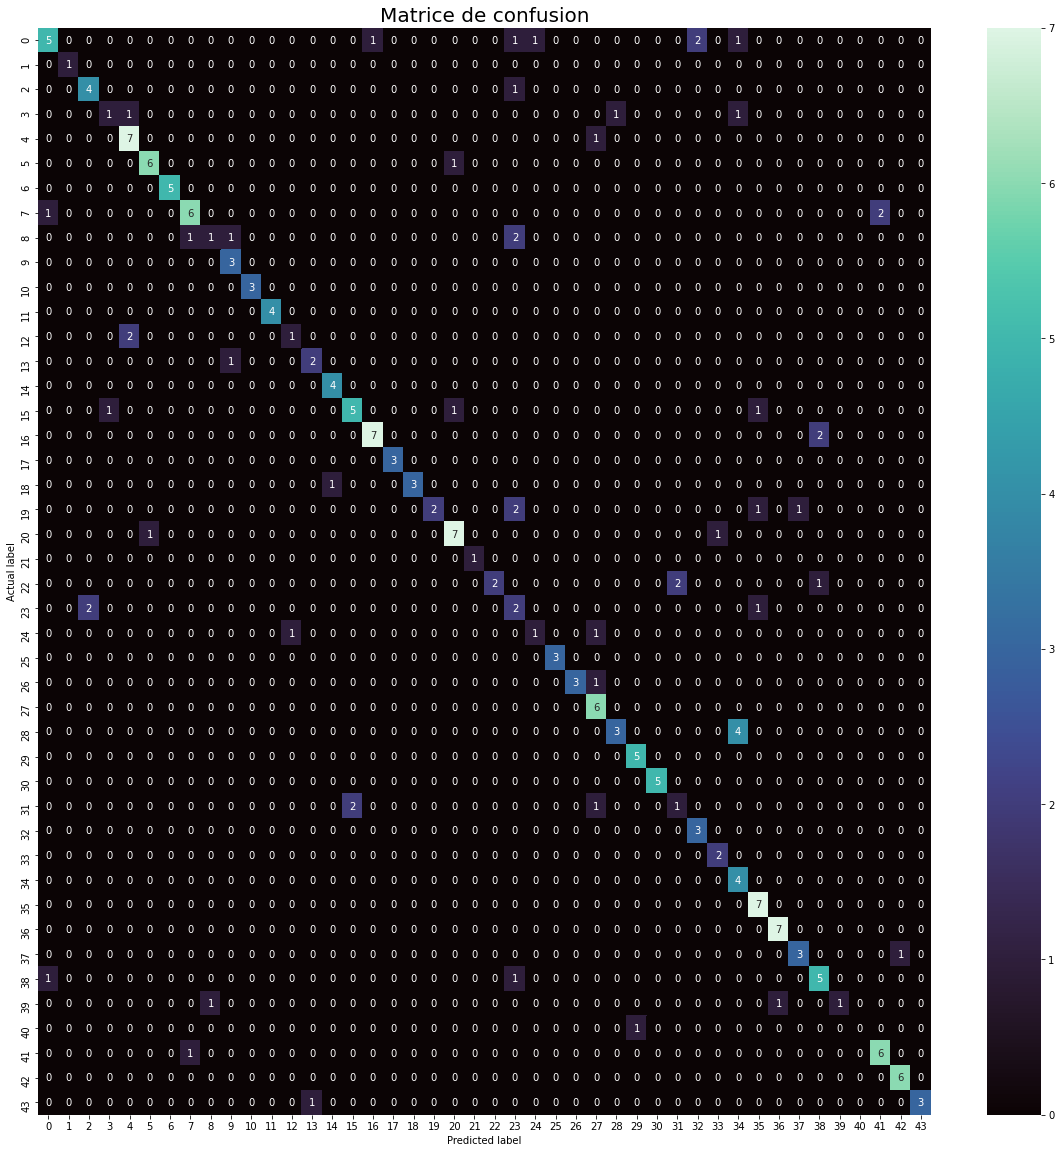

In [25]:
import seaborn as sns

cm = confusion_matrix(y_val , y_pred_2)
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt=".0f", cmap = 'mako')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("Matrice de confusion", size = 20)
plt.show()

### Historique

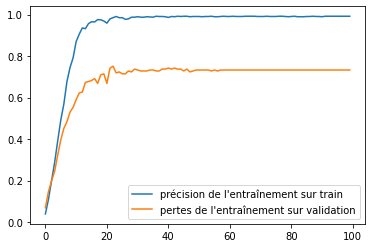

In [26]:
if train_model == True:
    #montrer l'historique de précision et des pertes
    plt.plot(history.history['accuracy'],label="précision de l'entraînement sur train")
    plt.plot(history.history['val_accuracy'],label="pertes de l'entraînement sur validation")
    plt.legend()

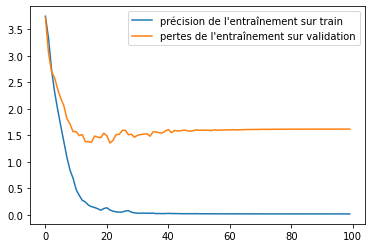

In [27]:
if train_model == True:
    #montrer l'historique de précision et des pertes
    plt.plot(history.history['loss'],label="précision de l'entraînement sur train")
    plt.plot(history.history['val_loss'],label="pertes de l'entraînement sur validation")
    plt.legend()

In [28]:
if train_model == False:
    model = load_model("model_py/model.h5")

## Test

Taper 0 pour sortir.

In [29]:
if test == True:
    while True:
      texts_p = []
      prediction_input = input('Vous : ')
      if prediction_input == "0":
        break

      #appliquer la fonction treatment
      prediction_input = treatment(prediction_input)
      texts_p.append(prediction_input)
      print(prediction_input)

      #tokenizer et padding
      prediction_input = tokenizer.texts_to_sequences(texts_p)
      prediction_input = np.array(prediction_input).reshape(-1)
      prediction_input = pad_sequences([prediction_input],input_shape)
      print(prediction_input)

      #obtenir la prédiction du modèle
      output = model.predict(prediction_input)
      output = output.argmax()
      print(output)

      #trouver la tag correspondante et la réponse
      response_tag = le.inverse_transform([output])[0]
      print(response_tag)
      #print("Chatbot : ",random.choice(responses[response_tag]))
      if response_tag == "goodbye":
        break

## API

In [30]:
if api == True:
    app = Flask(__name__)

    s_list = ["inconnu", "apprenant", "partenaire"]
    user_status = s_list[0]

    #créer deux listes de tags identifiant l'utilisateur comme étant apprenant ou partenaire
    appr_list = []
    part_list = []

    #créer deux dictionnaires avec les équivalents d'output apprenant/partenaire
    to_appr = {}
    to_part = {}


    #definir les app.route
    @app.route("/")
    def index():
        return render_template("index.html")

    @app.route("/get")
    #fonction de réponse
    def get_bot_response():
        #obtenir la question et la formatter
        texts_p = []
        prediction_input = request.args.get('msg')
        prediction_input = treatment(prediction_input)
        texts_p.append(prediction_input)

        #formatter l'input
        prediction_input = tokenizer.texts_to_sequences(texts_p)
        prediction_input = np.array(prediction_input).reshape(-1)
        prediction_input = pad_sequences([prediction_input],input_shape)

        #prédire l'output
        output = model.predict(prediction_input)
        output = output.argmax()

        #vérifier si l'output identifie l'utilisateur
        if output in appr_list:
            user_status = s_list[1]
        elif output in part_list:
            user_status = s_list[2]

        #si l'utilisateur est identifié et l'output est susceptible de changer pour ça, alors le changer
        if user_status == s_list[1] and output in to_appr.keys():
            output = to_appr[output]
        elif user_status == s_list[2] and output in to_part.keys():
            output = to_part[output]

        #transformer la réponse et la renvoyer
        response_tag = le.inverse_transform([output])[0]
        response = str("Chatbot : ",random.choice(responses[response_tag]))
        return response

    #lancer l'API
    if __name__ == "__main__":
        app.run()